In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from lstm2 import LSTMModel
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

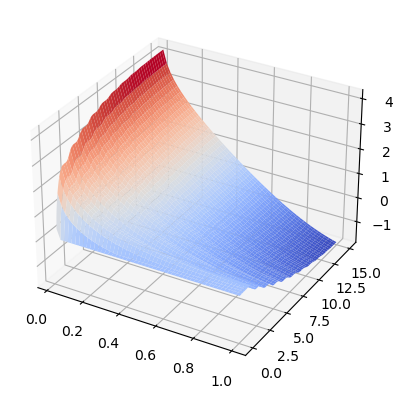

In [2]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("u.mat")["uData"]
x = x.reshape(npoints, nt, nx).astype(np.float32)
xArr = np.zeros((npoints, nt, 1))
for i in range(npoints):
    for j in range(nt):
        xArr[i][j][0] = x[i][j][0]
x = xArr.astype(np.float32)
y = scipy.io.loadmat("thetaHat.mat")["tHatData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    


x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[0, :, :], cmap=cm.coolwarm)

In [3]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes = 12
width = 32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

# Normalize
#x_normalizer = UnitGaussianNormalizer(x_train)
#y_normalizer = UnitGaussianNormalizer(y_train)
#x_train  = x_normalizer.encode(x_train)
#x_test = x_normalizer.encode(x_test)
#y_train = y_normalizer.encode(y_train)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
#model = LSTMModel(100, 1024, 100, 1, 3, [512, 128, 64]).cuda()
model = LSTMModel(500, 1, 50).cuda()
print(count_params(model))

1031050


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
t = default_timer()

loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        #out = y_normalizer.decode(out)
        #y = y_normalizer.decode(y)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            #out = y_normalizer.decode(out)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)

0 0.6691175119999571 0.7163139568434821 0.6665543794631958
50 0.4819998170000872 0.09089658715658717 0.08246428668498992
100 0.4816597279996131 0.047994967715607746 0.04770806208252907
150 0.48517547399978866 0.02874728110101488 0.03224269524216652
200 0.48573470600013025 0.021265983043445482 0.021947653219103812
250 0.4855098389998602 0.016909893871181542 0.01875282861292362
300 0.4856214530000216 0.014524384298258357 0.016154215671122074
350 0.4863206149998405 0.013508023156060114 0.01514429785311222
400 0.48583094100013113 0.01298025997562541 0.01470233015716076
450 0.48621356000012383 0.012669120708273517 0.01418185606598854
500 0.4853576589998738 0.012513761822548177 0.01406176295131445
550 0.48503874400012137 0.012427586399846606 0.013949104771018028
600 0.4860552150003059 0.012385033588442538 0.013910087384283542
650 0.4993177129999822 0.012357897207968765 0.013907614722847938
700 0.4914764469999682 0.012342690179745356 0.013903732225298882
750 0.4866197309997915 0.0123348230496

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


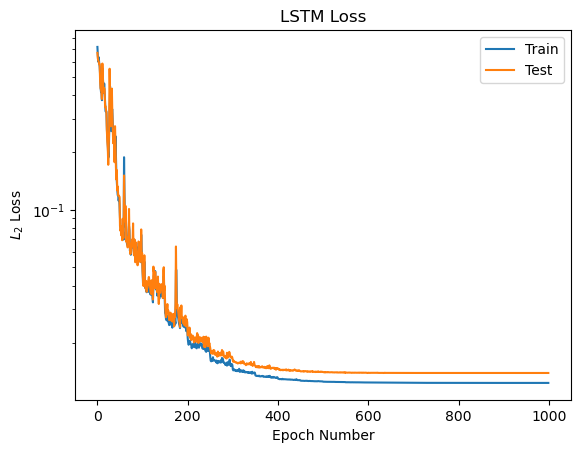

In [9]:
plt.title("LSTM Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('lstm.eps')

In [10]:
torch.save(model.state_dict(), 'lstmModel1')

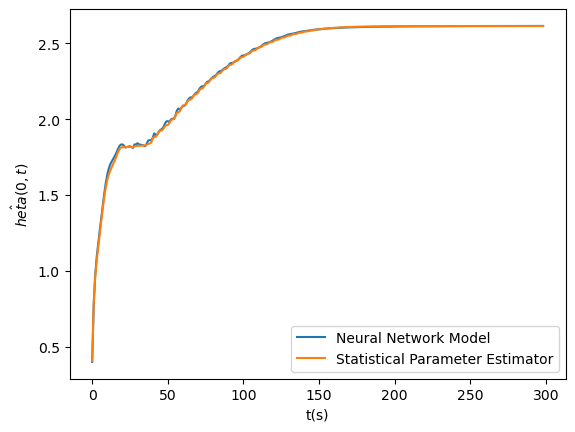

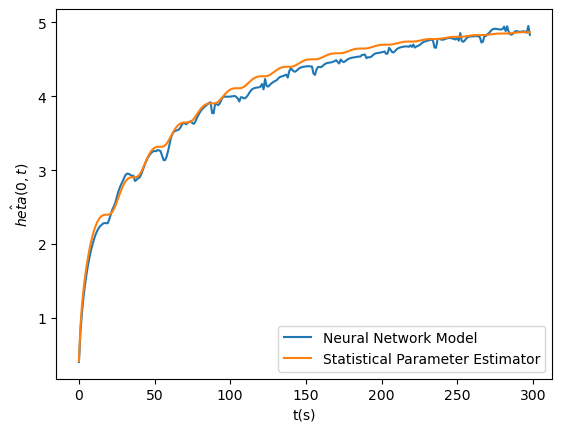

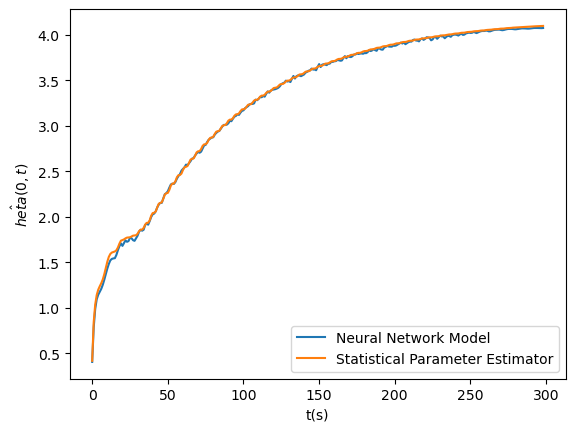

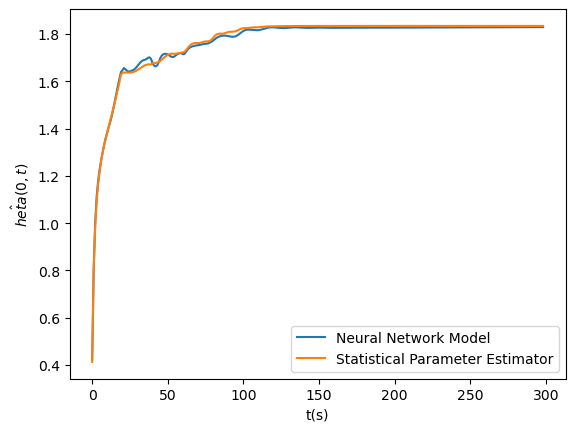

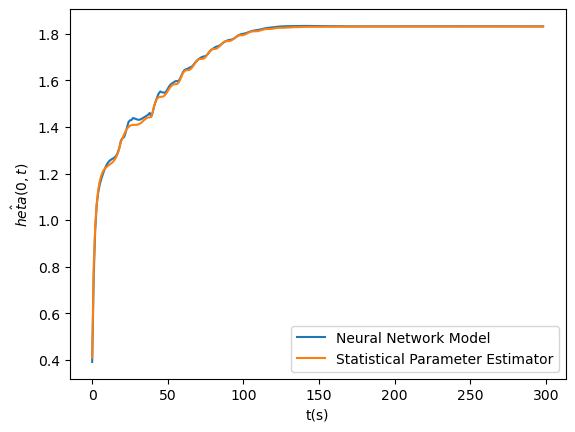

In [11]:
# Show some examples at the boundry
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        plt.figure()
        plt.plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        plt.plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        plt.legend()
        plt.xlabel("t(s)")
        plt.ylabel("$\hat{\theta}(0, t)$")

Text(0.5, 0, '$\\tilde{\\hat{\\theta}}$')

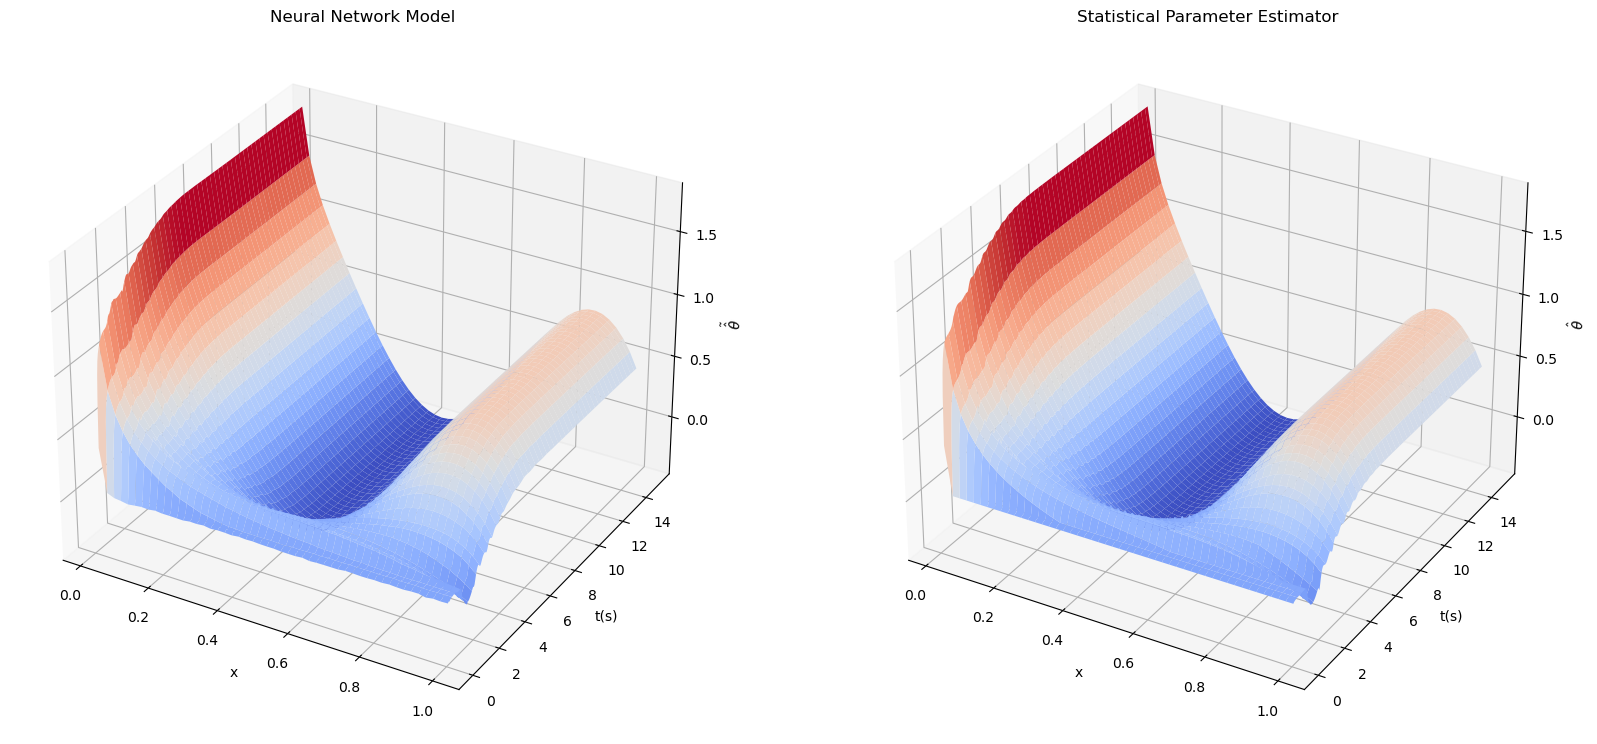

In [12]:
t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)
x1, t1 = np.meshgrid(x1, t1)

fig, ax = plt.subplots(1, 2,figsize=(20, 20), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(x1, t1, out.cpu().detach().numpy()[0, :, :], cmap=cm.coolwarm, label="Neural Network Model")
surf = ax[1].plot_surface(x1, t1, y.cpu().detach().numpy()[0, :, :], cmap=cm.coolwarm, label="Statistical Parameter Estimator")
ax[0].title.set_text("Neural Network Model")
ax[1].title.set_text("Statistical Parameter Estimator")
ax[0].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_ylabel("t(s)")
ax[1].set_ylabel("t(s)")
ax[1].set_zlabel(r'$\hat{\theta}$')
ax[0].set_zlabel(r'$\tilde{\hat{\theta}}$')

In [13]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)

        test_mse += loss(out, y).item()
print("TEST MSE For 20 Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.0139032032340765


In [14]:
torch.save(model.state_dict(), 'lstmModel1')